# Modified Rates

A {py:obj}`ModifiedRate <pynucastro.rates.modified_rate.ModifiedRate>` acts as a wrapper, encapsulating a single rate, allowing you to change the products of the stoichiometric coefficients.  A good example of this comes from the `aprox19` and `aprox21` networks.  There, an approximation to H-burning (via pp and CNO) is included, and the nucleus ${}^{14}\mathrm{N}$ is present, which is the bottleneck for CNO.  Beyond that is an $\alpha$-chain.  But $\alpha$-captures cannot connect ${}^{14}\mathrm{N}$ (odd $Z$) to the even-$Z$ nuclei in the $\alpha$-chain.

To make this connection, a rate that does:

$$2\, {}^{14}\mathrm{N} + 3 \alpha \rightarrow 2\, {}^{20}\mathrm{Ne}$$

is added.  For a single ${}^{14}\mathrm{N}$ we can write this as ${}^{14}\mathrm{N}(1.5\alpha,\gamma){}^{20}\mathrm{Ne}$. This is assumed to proceed at the rate for ${}^{14}\mathrm{N}(\alpha,\gamma){}^{18}\mathrm{F}$, and ${}^{18}\mathrm{F}$ is not included explicitly in the network.  But we can add this approximation using
`ModifiedRate`.

In [1]:
import pynucastro as pyna

We'll start with a basic network for He burning up to ${}^{20}\mathrm{Ne}$:

In [2]:
rl = pyna.ReacLibLibrary()
lib = rl.linking_nuclei(["he4", "c12", "o16", "ne20"],
                        with_reverse=False)

Now let's get the ${}^{14}\mathrm{N}(1.5\alpha,\gamma){}^{20}\mathrm{Ne}$ rate and modify it to go to
${}^{20}\mathrm{Ne}$.  To do this, we need to change the stoichiometric coefficients as well as the
products:

In [3]:
n14rate = rl.get_rate_by_name("n14(a,g)f18")

In [4]:
new_n14 = pyna.ModifiedRate(n14rate,
                            new_products=[pyna.Nucleus("ne20")],
                            stoichiometry={pyna.Nucleus("he4"): 1.5})

In [5]:
new_n14

N14 + 1.5 He4 ⟶ Ne20 + 𝛾

The modified rate still knows the underlying rate we will be evaluating:

In [6]:
new_n14.original_rate

N14 + He4 ⟶ F18 + 𝛾

and we can see that the function to compute the rate simply evaluates
the original rate and uses it.

In [7]:
print(new_n14.function_string_py())

@numba.njit()
def He4_N14_to_Ne20_modified(rate_eval, tf):
    # N14 + 1.5 He4 --> Ne20
    He4_N14_to_F18_reaclib(rate_eval, tf)
    rate_eval.He4_N14_to_Ne20_modified = rate_eval.He4_N14_to_F18_reaclib




Now we can add this new rate to our library:

In [8]:
lib.add_rate(new_n14)

and create the network from this library:

In [9]:
net = pyna.PythonNetwork(libraries=[lib])

The evolution for $dY({}^{4}\mathrm{He})/dt$ also uses the correct coefficient:

In [10]:
print(net.full_ydot_string(pyna.Nucleus("he4")))

dYdt[jhe4] = (
      -rho*Y[jhe4]*Y[jc12]*rate_eval.He4_C12_to_O16_reaclib  +
      -rho*Y[jhe4]*Y[jo16]*rate_eval.He4_O16_to_Ne20_reaclib  +
      +5.00000000000000e-01*rho*Y[jc12]**2*rate_eval.C12_C12_to_He4_Ne20_reaclib  +
      + -3*1.66666666666667e-01*rho**2*Y[jhe4]**3*rate_eval.He4_He4_He4_to_C12_reaclib  +
      + -1.5*rho*Y[jhe4]*Y[jn14]*rate_eval.He4_N14_to_Ne20_modified
   )




Here's a visualization with the links from the new rate highlighted:

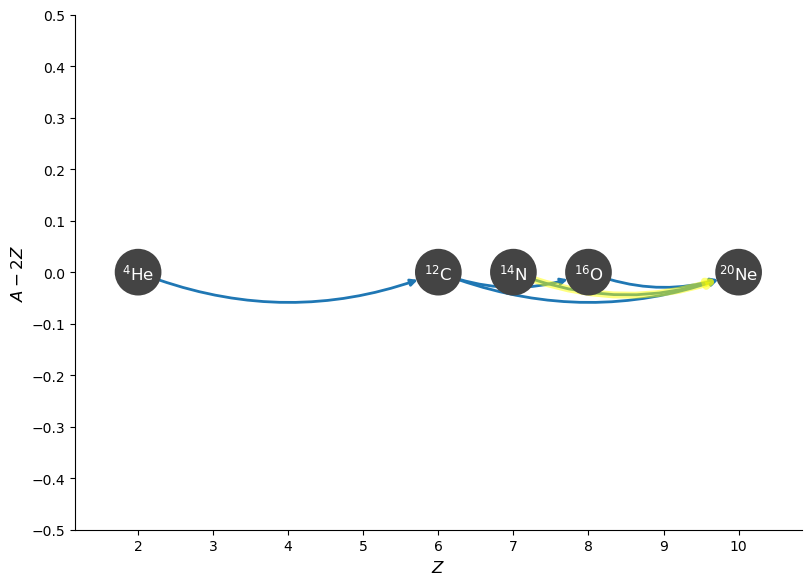

In [11]:
fig = net.plot(curved_edges=True, rotated=True, hide_xalpha=True,
               highlight_filter_function=lambda r: pyna.Nucleus("n14") in r.reactants)

and the evaluation of the rates at a particular thermodynamic state:

In [12]:
rho = 1.e6
T = 5.e8
comp = pyna.Composition(net.unique_nuclei)
comp.set_equal()

In [13]:
net.evaluate_rates(rho=rho, T=T, composition=comp)

{C12 + He4 ⟶ O16 + 𝛾: 3.1635370410117465e-06,
 O16 + He4 ⟶ Ne20 + 𝛾: 0.00010189935467071995,
 C12 + C12 ⟶ He4 + Ne20: 2.1912364485182727e-18,
 3 He4 ⟶ C12 + 𝛾: 0.0007011536816900648,
 N14 + 1.5 He4 ⟶ Ne20 + 𝛾: 0.08158832557453448}